<a href="https://colab.research.google.com/github/chris-william0829/fgsmattack/blob/main/I_FGSM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import os.path

In [23]:
# 数据加载
train_data = torchvision.datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
test_data = torchvision.datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

batch_size = 64

train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size)
test_dataloader = DataLoader(dataset=test_data, batch_size=1)

In [24]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1,6,3,stride=1,padding=1),
            nn.MaxPool2d(2,2),
            nn.Conv2d(6,16,5,stride=1,padding=1),
            nn.MaxPool2d(2,2)
        )
        self.fc = nn.Sequential(
            nn.Linear(576,120),
            nn.Linear(120,84),
            nn.Linear(84,10)
        )
    def forward(self,x):
        out = self.conv(x)
        out = out.view(out.size(0),-1)
        out = self.fc(out)
        return out

In [25]:
def train(network):

    losses = []
    iteration = 0

    epochs = 10

    for epoch in range(epochs):
        loss_sum = 0
        for i, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)

            pred = network(X)
            loss = loss_fn(pred, y)

            loss_sum += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        mean_loss = loss_sum / len(train_dataloader.dataset)
        losses.append(mean_loss)
        iteration += 1
        print(f"Epoch {epoch+1} loss: {mean_loss:>7f}")

    # 训练完毕保存最后一轮训练的模型
    torch.save(network.state_dict(), "model.pth")

    # 绘制损失函数曲线
    plt.xlabel("Epochs")
    plt.ylabel("Loss Value")
    plt.plot(list(range(iteration)), losses)

In [26]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [27]:
network = LeNet()
network.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=network.parameters(), lr=0.001, momentum=0.9)

if os.path.exists('model.pth'):
    network.load_state_dict(torch.load('model.pth'))
else:
    train(network)

In [28]:
positive = 0
negative = 0
for data, target in test_dataloader:
    with torch.no_grad():
        data, target = data.to(device), target.to(device)
        pred = network(data)
        for item in zip(pred, target):
            if torch.argmax(item[0]) == item[1]:
                positive += 1
            else:
                negative += 1
acc = positive / (positive + negative)
print(f"Accuracy: {acc * 100}%")

Accuracy: 97.8%


In [29]:
def fgsm_attack(input,epsilon,data_grad):
  pert_out = input + epsilon*data_grad.sign()
  pert_out = torch.clamp(pert_out, 0, 1)
  return pert_out

def ifgsm_attack(input,epsilon,data_grad):
  iter = 10
  alpha = epsilon/iter
  pert_out = input
  for i in range(iter-1):
    pert_out = pert_out + alpha*data_grad.sign()
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

def mifgsm_attack(input,epsilon,data_grad):
  iter=10
  decay_factor=1.0
  pert_out = input
  alpha = epsilon/iter
  g=0
  for i in range(iter-1):
    g = decay_factor*g + data_grad/torch.norm(data_grad,p=1)
    pert_out = pert_out + alpha*torch.sign(g)
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

Epsilon: 0.2	Test Accuracy = 0.9369120654396728
Epsilon: 0.21000000000000002	Test Accuracy = 0.9513292433537832
fgsm


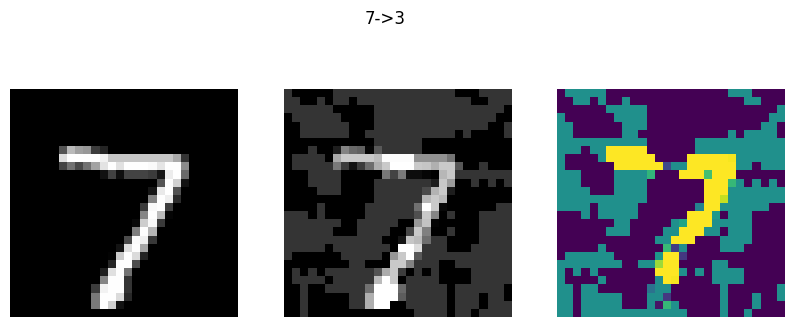

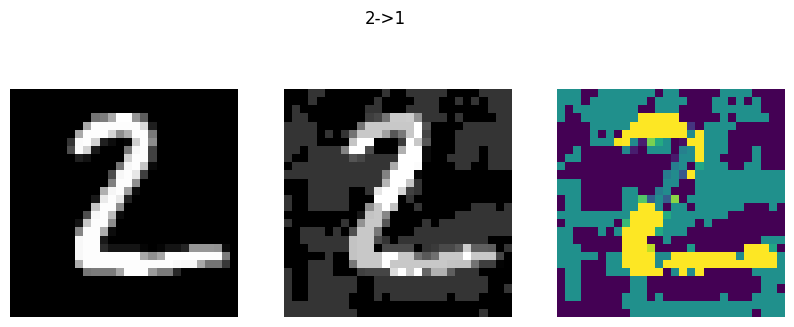

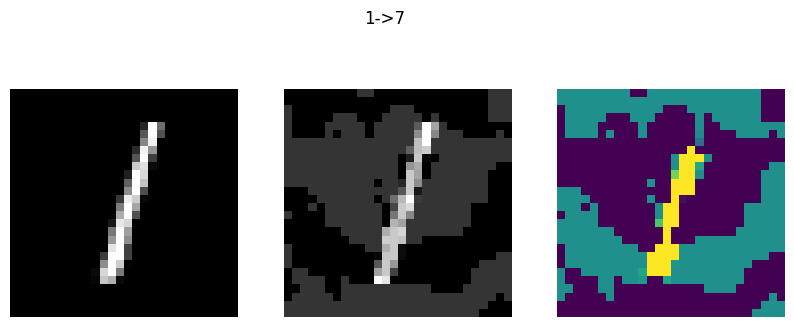

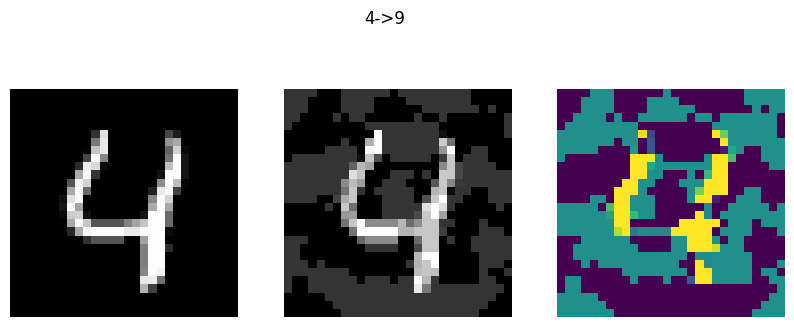

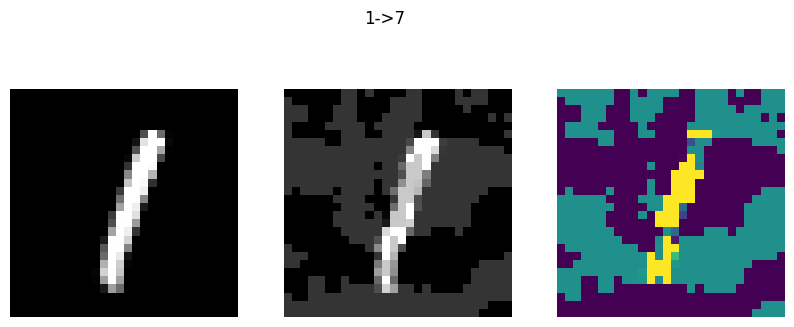

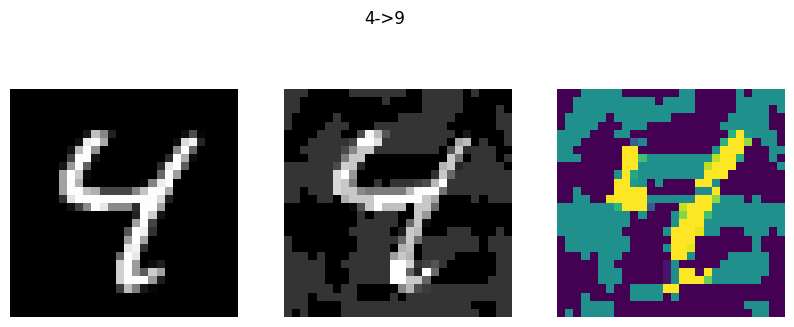

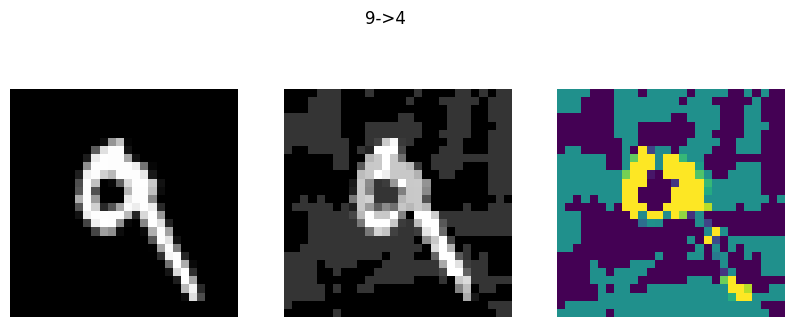

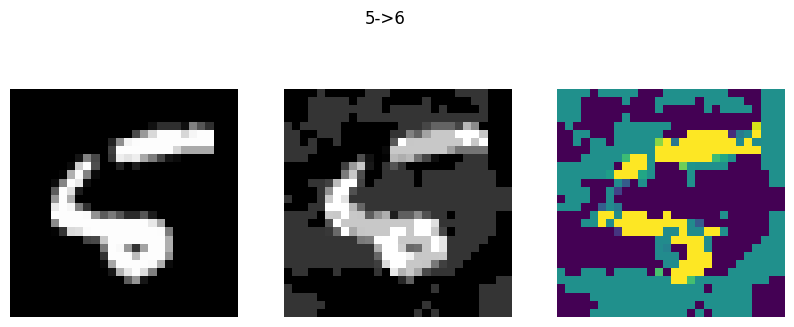

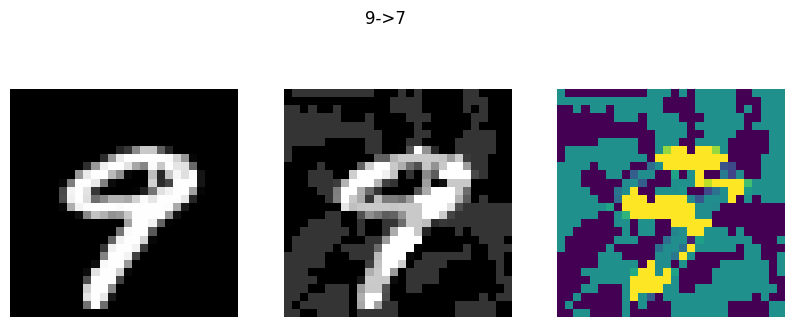

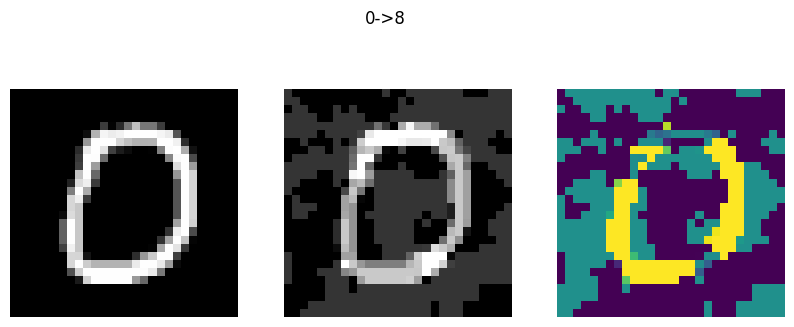

Epsilon: 0.2	Test Accuracy = 0.8851738241308793
Epsilon: 0.21000000000000002	Test Accuracy = 0.9133946830265849
Epsilon: 0.22000000000000003	Test Accuracy = 0.9333333333333333
Epsilon: 0.23000000000000004	Test Accuracy = 0.9465235173824131
Epsilon: 0.24000000000000005	Test Accuracy = 0.9594069529652351
ifgsm


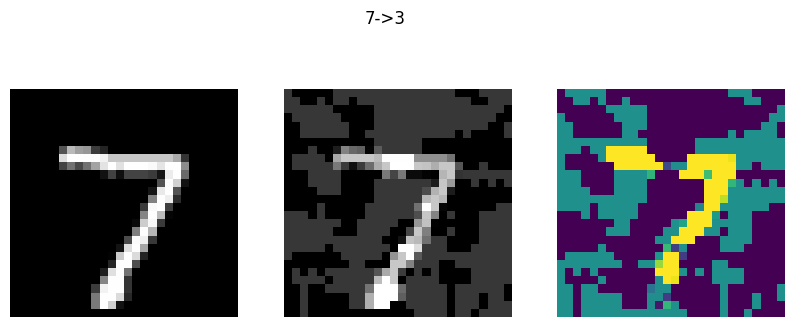

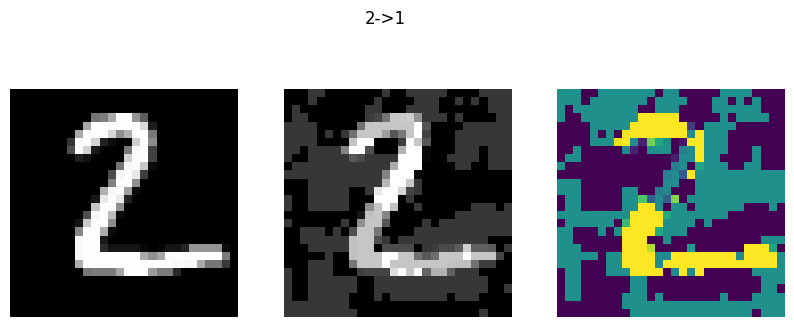

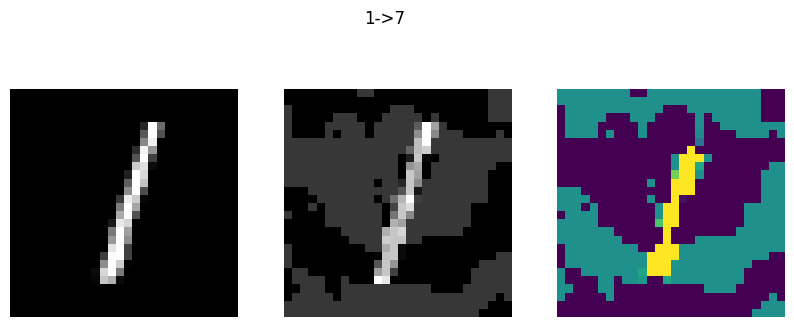

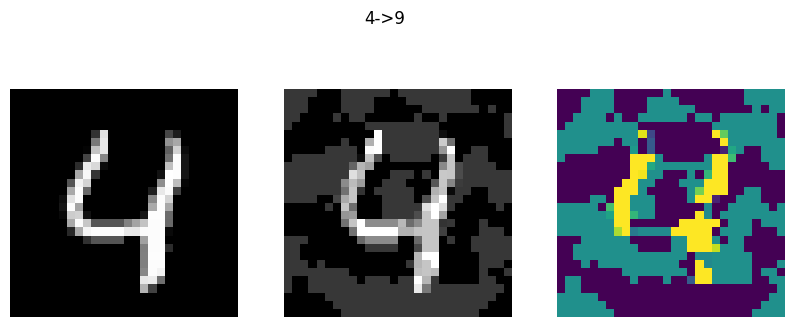

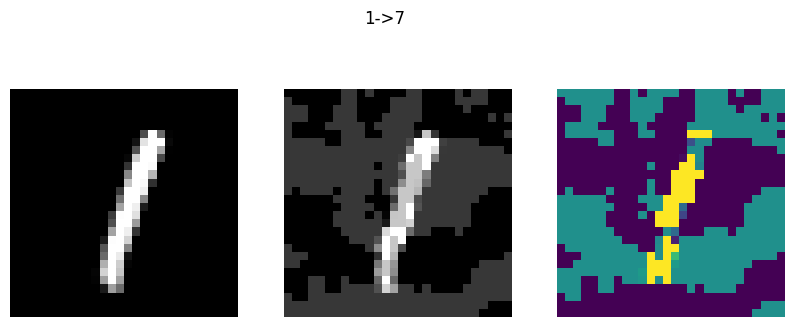

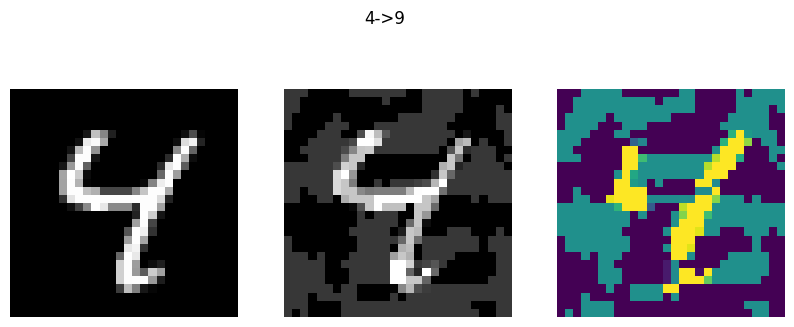

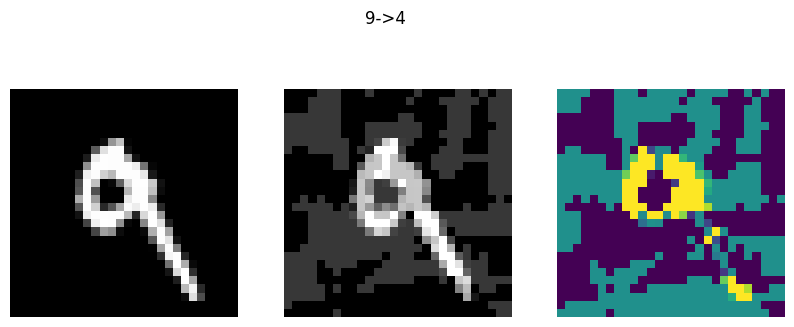

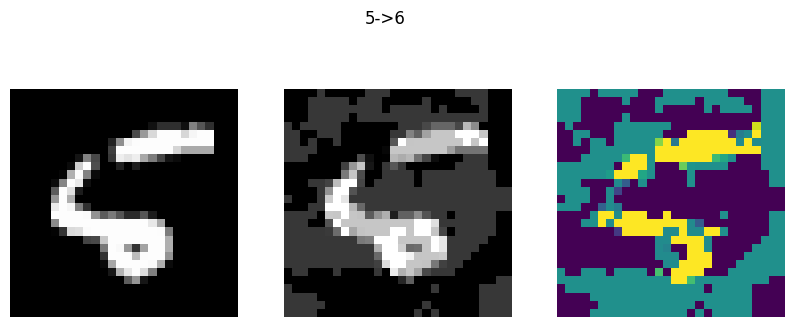

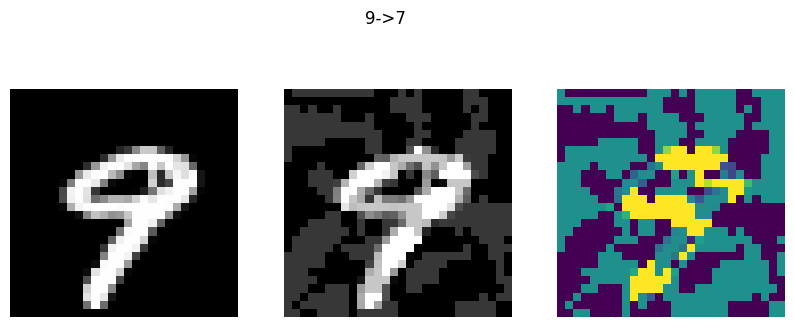

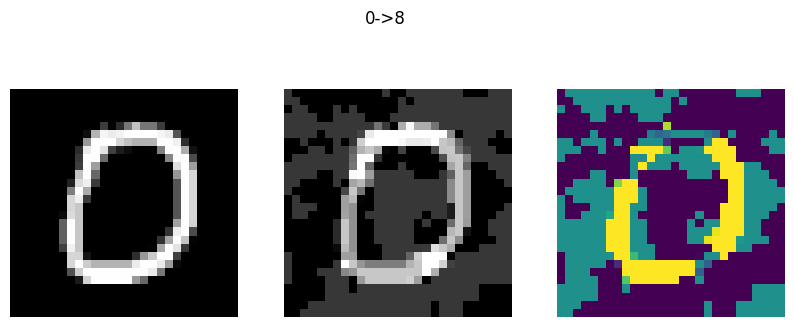

Epsilon: 0.2	Test Accuracy = 0.8851738241308793
Epsilon: 0.21000000000000002	Test Accuracy = 0.9133946830265849
Epsilon: 0.22000000000000003	Test Accuracy = 0.9333333333333333
Epsilon: 0.23000000000000004	Test Accuracy = 0.9465235173824131
Epsilon: 0.24000000000000005	Test Accuracy = 0.9594069529652351
mifgsm


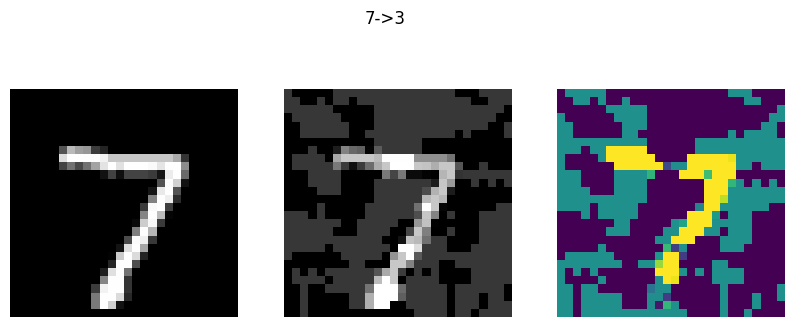

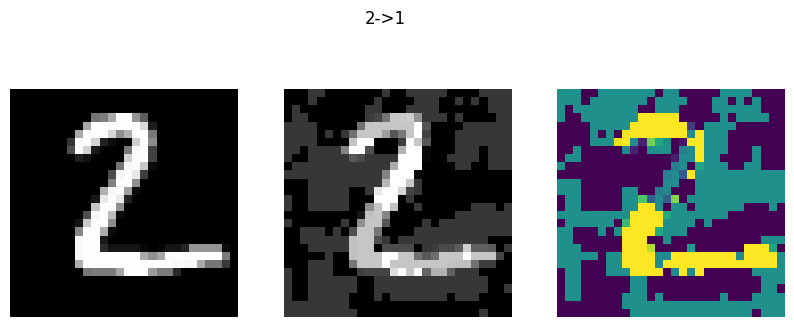

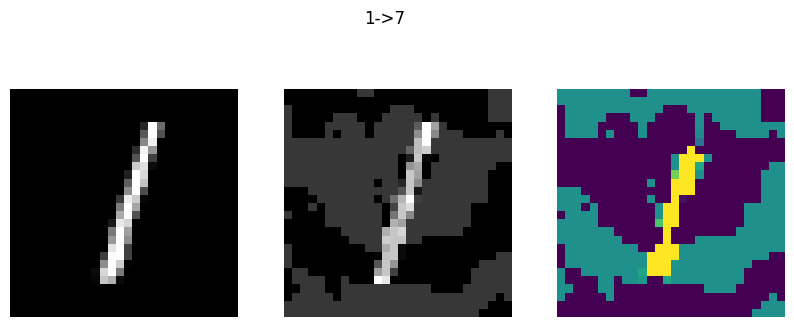

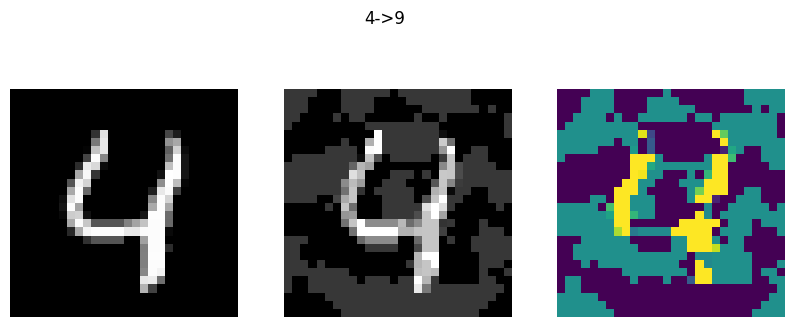

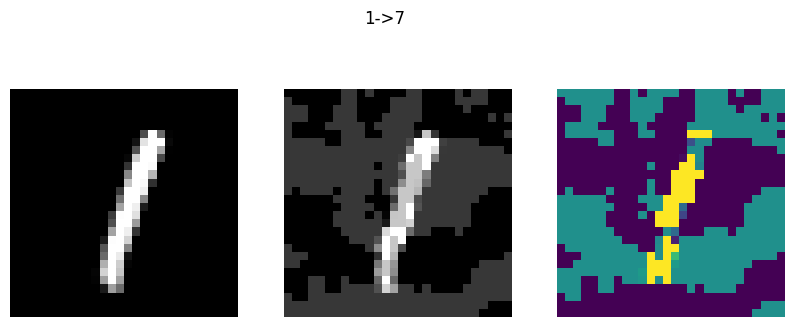

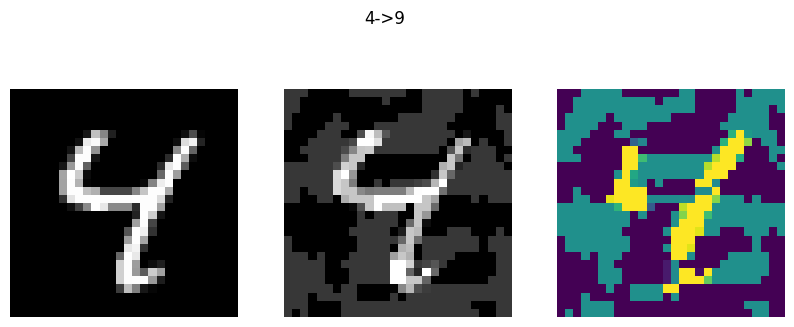

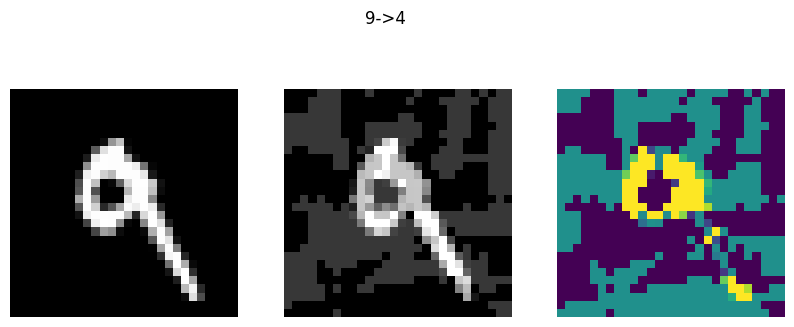

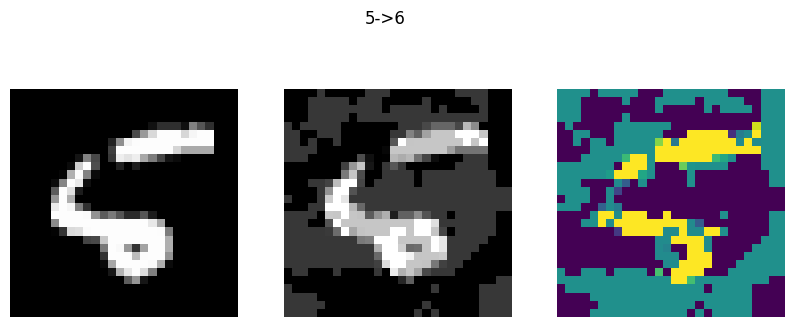

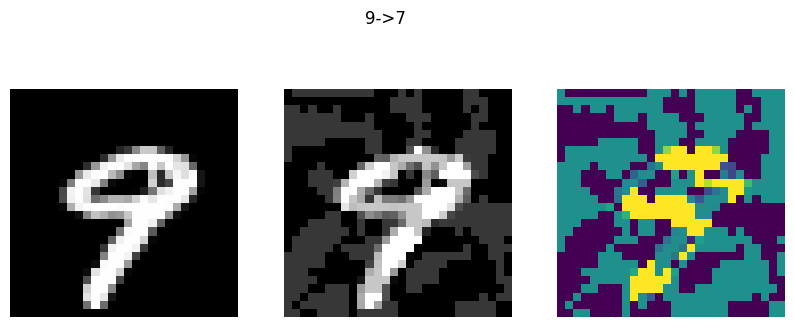

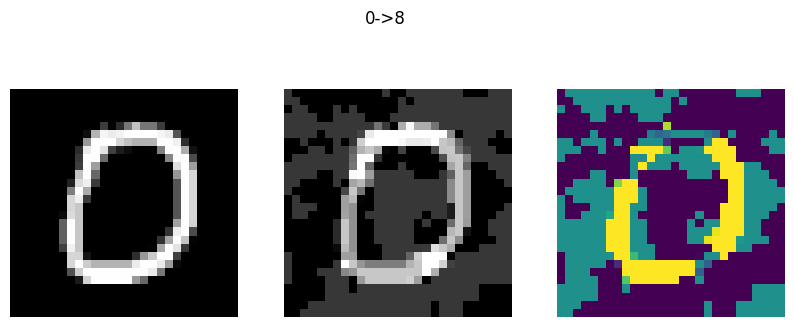

In [33]:
for attack in ("fgsm","ifgsm","mifgsm"):
  eps = 0.2
  while(1):
    positive = 0
    negative = 0
    examples = []
    adv_examples = []
    for data, target in test_dataloader:
      data, target = data.to(device), target.to(device)
      data.requires_grad = True
      pred = network(data)
      network.zero_grad()
      loss = loss_fn(pred, target)
      loss.backward()
      data_grad = data.grad.data
      orig_pred = np.argmax(pred.cpu().detach().numpy())
      if orig_pred != target:
        continue
      if attack == "fgsm":
        perturbed_data = fgsm_attack(data,eps,data_grad)
      elif attack == "ifgsm":
        perturbed_data = ifgsm_attack(data,eps,data_grad)
      elif attack == "mifgsm":
        perturbed_data = mifgsm_attack(data,eps,data_grad)
      output = network(perturbed_data)
      final_pred = np.argmax(output.cpu().detach().numpy())
      if final_pred != orig_pred:
        positive += 1
        if len(examples) < 10:
          ex = data.squeeze().detach().cpu().numpy()
          adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
          examples.append((orig_pred,ex))
          adv_examples.append((final_pred,adv_ex))
      else:
        negative += 1
    acc = positive / (positive + negative)
    print("Epsilon: {}\tTest Accuracy = {}".format(eps, acc))
    if acc > 0.95:
      break
    else:
      eps += 0.01
  print(attack)    
  for i in range(len(examples)):
    # 创建一个1*3的子图
    fig, axs = plt.subplots(1, 3, figsize=(10, 4))
    diff = np.subtract(examples[i][1],adv_examples[i][1])
    axs[0].imshow(examples[i][1],cmap="gray")
    axs[0].axis('off')
    axs[1].imshow(adv_examples[i][1],cmap="gray")
    axs[1].axis('off')
    axs[2].imshow(diff)
    axs[2].axis('off')
    fig.suptitle("{}->{}".format(examples[i][0],adv_examples[i][0]))
    plt.show()